In [1]:
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot3 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

import pickle

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from IPython.display import display

# should be xgboost v1.3.0, needs to be old in order to calculate the score correctly!
# uproot can be any version 3 I think
print(xgb.__version__)
print(uproot.__version__)

1.3.0
3.14.4


In [2]:
# This is a list of the scalar variables saved for the numu tagger

numu3_var = ["numu_cc_flag_3",
"numu_cc_3_particle_type",
"numu_cc_3_max_length",
"numu_cc_3_track_length",#numu_cc_3_acc_track_length'
"numu_cc_3_max_length_all",
"numu_cc_3_max_muon_length",
"numu_cc_3_n_daughter_tracks",
"numu_cc_3_n_daughter_all"]

cosmict24_var = ["cosmict_flag_2",
"cosmict_2_filled",
"cosmict_2_particle_type",
"cosmict_2_n_muon_tracks",
"cosmict_2_total_shower_length",
"cosmict_2_flag_inside",
"cosmict_2_angle_beam",
"cosmict_2_flag_dir_weak",
"cosmict_2_dQ_dx_end",
"cosmict_2_dQ_dx_front",
"cosmict_2_theta",
"cosmict_2_phi",
"cosmict_2_valid_tracks",
"cosmict_flag_4", 
"cosmict_4_filled",
"cosmict_4_flag_inside",
"cosmict_4_angle_beam",
"cosmict_4_connected_showers"]

cosmict35_var = ["cosmict_flag_3",
"cosmict_3_filled",
"cosmict_3_flag_inside",
"cosmict_3_angle_beam",
"cosmict_3_flag_dir_weak",
"cosmict_3_dQ_dx_end",
"cosmict_3_dQ_dx_front",
"cosmict_3_theta",
"cosmict_3_phi",
"cosmict_3_valid_tracks",
"cosmict_flag_5",  
"cosmict_5_filled",
"cosmict_5_flag_inside",
"cosmict_5_angle_beam",
"cosmict_5_connected_showers"]

cosmict6_var = ["cosmict_flag_6", 
"cosmict_6_filled",
"cosmict_6_flag_dir_weak",
"cosmict_6_flag_inside",
"cosmict_6_angle"]

cosmict7_var = ["cosmict_flag_7",
"cosmict_7_filled",
"cosmict_7_flag_sec",
"cosmict_7_n_muon_tracks",
"cosmict_7_total_shower_length",
"cosmict_7_flag_inside",
"cosmict_7_angle_beam",
"cosmict_7_flag_dir_weak",
"cosmict_7_dQ_dx_end",
"cosmict_7_dQ_dx_front",
"cosmict_7_theta",
"cosmict_7_phi"]

cosmict8_var = ["cosmict_flag_8", 
"cosmict_8_filled",
"cosmict_8_flag_out",
"cosmict_8_muon_length",
"cosmict_8_acc_length"]

cosmict9_var = ["cosmict_flag_9",
"cosmic_flag",
"cosmic_filled"]

overall_var = ["cosmict_flag",
"numu_cc_flag"]

all_numu_scalars = []
all_numu_scalars += numu3_var
all_numu_scalars += cosmict24_var
all_numu_scalars += cosmict35_var
all_numu_scalars += cosmict6_var
all_numu_scalars += cosmict7_var
all_numu_scalars += cosmict8_var
all_numu_scalars += cosmict9_var
all_numu_scalars += overall_var

all_numu_scalars += ["cosmict_flag_1", "kine_reco_Enu", "match_isFC"]

In [3]:
# this is a list of the vector variables saved for the numu tagger (currently not using these for training, that would be more complicated)

var_numu1 = [#'weight',
             #'numu_cc_flag',
             #'cosmict_flag_1',
             #'numu_cc_flag_1',
             'numu_cc_1_particle_type',
             'numu_cc_1_length',
             'numu_cc_1_medium_dQ_dx',
             'numu_cc_1_dQ_dx_cut',
             'numu_cc_1_direct_length',
             'numu_cc_1_n_daughter_tracks',
             'numu_cc_1_n_daughter_all']
var_numu2 = [#'weight',
             #'numu_cc_flag',
             #'cosmict_flag_1',
             #'numu_cc_flag_2',
             'numu_cc_2_length',
             'numu_cc_2_total_length',
             'numu_cc_2_n_daughter_tracks',
             'numu_cc_2_n_daughter_all']
var_cos10 = [#'weight',
             #'numu_cc_flag',
             #'cosmict_flag_1',
             #'cosmict_flag_10',
             #'cosmict_10_flag_inside',
             'cosmict_10_vtx_z',
             'cosmict_10_flag_shower',
             'cosmict_10_flag_dir_weak',
             'cosmict_10_angle_beam',
             'cosmict_10_length']

all_numu_vectors = []
all_numu_vectors += var_numu1
all_numu_vectors += var_numu2
all_numu_vectors += var_cos10

In [4]:
taggerCMEAMC_var = ["cme_mu_energy","cme_energy","cme_mu_length","cme_length",
                "cme_angle_beam","anc_angle","anc_max_angle","anc_max_length",
                "anc_acc_forward_length","anc_acc_backward_length","anc_acc_forward_length1",
                "anc_shower_main_length","anc_shower_total_length","anc_flag_main_outside"]

taggerGAP_var = ["gap_flag_prolong_u","gap_flag_prolong_v","gap_flag_prolong_w","gap_flag_parallel",
                 "gap_n_points","gap_n_bad","gap_energy","gap_num_valid_tracks","gap_flag_single_shower"]

taggerHOL_var = ["hol_1_n_valid_tracks","hol_1_min_angle","hol_1_energy","hol_1_flag_all_shower","hol_1_min_length",
               "hol_2_min_angle","hol_2_medium_dQ_dx","hol_2_ncount","lol_3_angle_beam","lol_3_n_valid_tracks",
               "lol_3_min_angle","lol_3_vtx_n_segs","lol_3_shower_main_length","lol_3_n_out","lol_3_n_sum"]

taggerMGOMGT_var = ["mgo_energy","mgo_max_energy","mgo_total_energy","mgo_n_showers","mgo_max_energy_1",
                    "mgo_max_energy_2","mgo_total_other_energy","mgo_n_total_showers","mgo_total_other_energy_1",
                   "mgt_flag_single_shower","mgt_max_energy","mgt_total_other_energy","mgt_max_energy_1",
                   "mgt_e_indirect_max_energy","mgt_e_direct_max_energy","mgt_n_direct_showers",
                    "mgt_e_direct_total_energy","mgt_flag_indirect_max_pio","mgt_e_indirect_total_energy"]

taggerMIPQUALITY_var = ["mip_quality_energy","mip_quality_overlap","mip_quality_n_showers","mip_quality_n_tracks",
                        "mip_quality_flag_inside_pi0","mip_quality_n_pi0_showers","mip_quality_shortest_length",
                        "mip_quality_acc_length","mip_quality_shortest_angle","mip_quality_flag_proton"]

taggerBR1_var = ["br1_1_shower_type","br1_1_vtx_n_segs","br1_1_energy","br1_1_n_segs","br1_1_flag_sg_topology",
                 "br1_1_flag_sg_trajectory","br1_1_sg_length","br1_2_n_connected","br1_2_max_length",
                "br1_2_n_connected_1","br1_2_n_shower_segs","br1_2_max_length_ratio","br1_2_shower_length",
                 "br1_3_n_connected_p","br1_3_max_length_p","br1_3_n_shower_main_segs"]

taggerBR3_var = ["br3_1_energy","br3_1_n_shower_segments","br3_1_sg_flag_trajectory","br3_1_sg_direct_length",
                "br3_1_sg_length","br3_1_total_main_length","br3_1_total_length","br3_1_iso_angle",
                 "br3_1_sg_flag_topology","br3_2_n_ele","br3_2_n_other","br3_2_other_fid","br3_4_acc_length",
                 "br3_4_total_length","br3_7_min_angle","br3_8_max_dQ_dx","br3_8_n_main_segs"]

taggerBR4TRE_var = ["br4_1_shower_main_length","br4_1_shower_total_length","br4_1_min_dis","br4_1_energy",
                    "br4_1_flag_avoid_muon_check","br4_1_n_vtx_segs","br4_1_n_main_segs","br4_2_ratio_45",
                   "br4_2_ratio_35","br4_2_ratio_25","br4_2_ratio_15","br4_2_ratio1_45","br4_2_ratio1_35",
                   "br4_2_ratio1_25","br4_2_ratio1_15","br4_2_iso_angle","br4_2_iso_angle1","br4_2_angle",
                   "tro_3_stem_length","tro_3_n_muon_segs"]

taggerVIS1_var = ["vis_1_n_vtx_segs","vis_1_energy","vis_1_num_good_tracks","vis_1_max_angle",
                  "vis_1_max_shower_angle","vis_1_tmp_length1","vis_1_tmp_length2"]

taggerVIS2_var = ["vis_2_n_vtx_segs","vis_2_min_angle","vis_2_min_weak_track","vis_2_angle_beam","vis_2_min_angle1",
                 "vis_2_iso_angle1","vis_2_min_medium_dQ_dx","vis_2_min_length","vis_2_sg_length","vis_2_max_angle",
                 "vis_2_max_weak_track"]

taggerPI01_var = ["pio_1_mass","pio_1_pio_type","pio_1_energy_1","pio_1_energy_2","pio_1_dis_1","pio_1_dis_2","pio_mip_id"]

taggerSTEMDIRBR2_var = ["stem_dir_flag_single_shower","stem_dir_angle","stem_dir_energy","stem_dir_angle1",
                        "stem_dir_angle2","stem_dir_angle3","stem_dir_ratio","br2_num_valid_tracks",
                        "br2_n_shower_main_segs","br2_max_angle","br2_sg_length","br2_flag_sg_trajectory"]

taggerSTLLEMBRM_var = ["stem_len_energy","stem_len_length","stem_len_flag_avoid_muon_check","stem_len_num_daughters",
                      "stem_len_daughter_length","brm_n_mu_segs","brm_Ep","brm_acc_length","brm_shower_total_length",
                      "brm_connected_length","brm_n_size","brm_acc_direct_length","brm_n_shower_main_segs",
                       "brm_n_mu_main","lem_shower_main_length","lem_n_3seg","lem_e_charge","lem_e_dQdx",
                       "lem_shower_num_main_segs"]

taggerSTWSPT_var = ["stw_1_energy","stw_1_dis","stw_1_dQ_dx","stw_1_flag_single_shower","stw_1_n_pi0",
                    "stw_1_num_valid_tracks","spt_shower_main_length","spt_shower_total_length","spt_angle_beam",
                    "spt_angle_vertical","spt_max_dQ_dx","spt_angle_beam_1","spt_angle_drift","spt_angle_drift_1",
                    "spt_num_valid_tracks","spt_n_vtx_segs","spt_max_length"]

taggerMIP_var = ["mip_energy","mip_n_end_reduction","mip_n_first_mip","mip_n_first_non_mip","mip_n_first_non_mip_1",
                "mip_n_first_non_mip_2","mip_vec_dQ_dx_0","mip_vec_dQ_dx_1","mip_max_dQ_dx_sample",
                "mip_n_below_threshold","mip_n_below_zero","mip_n_lowest","mip_n_highest","mip_lowest_dQ_dx",
                 "mip_highest_dQ_dx","mip_medium_dQ_dx","mip_stem_length","mip_length_main","mip_length_total",
                 "mip_angle_beam","mip_iso_angle","mip_n_vertex","mip_n_good_tracks","mip_E_indirect_max_energy",
                 "mip_flag_all_above","mip_min_dQ_dx_5","mip_n_other_vertex","mip_n_stem_size",
                 "mip_flag_stem_trajectory","mip_min_dis"]

taggerAdditional_Var = ["mip_vec_dQ_dx_2","mip_vec_dQ_dx_3","mip_vec_dQ_dx_4","mip_vec_dQ_dx_5","mip_vec_dQ_dx_6",
                        "mip_vec_dQ_dx_7","mip_vec_dQ_dx_8","mip_vec_dQ_dx_9","mip_vec_dQ_dx_10","mip_vec_dQ_dx_11",
                        "mip_vec_dQ_dx_12","mip_vec_dQ_dx_13","mip_vec_dQ_dx_14","mip_vec_dQ_dx_15",
                        "mip_vec_dQ_dx_16","mip_vec_dQ_dx_17","mip_vec_dQ_dx_18","mip_vec_dQ_dx_19"]


all_nue_scalars = []
all_nue_scalars += taggerCMEAMC_var
all_nue_scalars += taggerGAP_var
all_nue_scalars += taggerHOL_var
all_nue_scalars += taggerMGOMGT_var
all_nue_scalars += taggerMIPQUALITY_var
all_nue_scalars += taggerBR1_var
all_nue_scalars += taggerBR3_var
all_nue_scalars += taggerBR4TRE_var
all_nue_scalars += taggerSTEMDIRBR2_var
all_nue_scalars += taggerSTLLEMBRM_var
all_nue_scalars += taggerSTWSPT_var
all_nue_scalars += taggerMIP_var
all_nue_scalars += taggerVIS1_var
all_nue_scalars += taggerVIS2_var
all_nue_scalars += taggerPI01_var
all_nue_scalars += taggerAdditional_Var

# removing this line, these variables are already in all_numu_scalars
#all_nue_scalars += ["kine_reco_Enu", "match_isFC"]

In [5]:
taggerTRO5_var = ["tro_5_v_max_angle","tro_5_v_min_angle","tro_5_v_max_length","tro_5_v_iso_angle","tro_5_v_n_vtx_segs",
                "tro_5_v_min_count","tro_5_v_max_count","tro_5_v_energy"]
 
taggerTRO4_var = ["tro_4_v_dir2_mag","tro_4_v_angle","tro_4_v_angle1","tro_4_v_angle2","tro_4_v_length","tro_4_v_length1",
                "tro_4_v_medium_dQ_dx","tro_4_v_end_dQ_dx","tro_4_v_energy","tro_4_v_shower_main_length","tro_4_v_flag_shower_trajectory"]

taggerTRO2_var = ["tro_2_v_energy","tro_2_v_stem_length","tro_2_v_iso_angle","tro_2_v_max_length","tro_2_v_angle"]
 
taggerTRO1_var = ["tro_1_v_particle_type","tro_1_v_flag_dir_weak","tro_1_v_min_dis","tro_1_v_sg1_length","tro_1_v_shower_main_length",
                "tro_1_v_max_n_vtx_segs","tro_1_v_tmp_length","tro_1_v_medium_dQ_dx","tro_1_v_dQ_dx_cut","tro_1_v_flag_shower_topology"]
 
taggerSTW4_var = ["stw_4_v_angle","stw_4_v_dis","stw_4_v_energy"]
 
taggerSTW3_var = ["stw_3_v_angle","stw_3_v_dir_length","stw_3_v_energy","stw_3_v_medium_dQ_dx"]
 
taggerSTW2_var = ["stw_2_v_medium_dQ_dx","stw_2_v_energy","stw_2_v_angle","stw_2_v_dir_length","stw_2_v_max_dQ_dx"]
 
taggerSIG2_var = ["sig_2_v_energy","sig_2_v_shower_angle","sig_2_v_flag_single_shower","sig_2_v_medium_dQ_dx",
                "sig_2_v_start_dQ_dx"]
taggerSIG1_var = ["sig_1_v_angle","sig_1_v_flag_single_shower","sig_1_v_energy","sig_1_v_energy_1"]
 
taggerPI02_var = ["pio_2_v_dis2","pio_2_v_angle2","pio_2_v_acc_length"]#"pio_mip_id"
 
taggerLOL2_var = ["lol_2_v_length","lol_2_v_angle","lol_2_v_type","lol_2_v_vtx_n_segs","lol_2_v_energy",
                 "lol_2_v_shower_main_length","lol_2_v_flag_dir_weak"]
taggerLOL1_var = ["lol_1_v_energy","lol_1_v_vtx_n_segs","lol_1_v_nseg","lol_1_v_angle"]
 
taggerBR3TAGGER6_var = ["br3_6_v_angle","br3_6_v_angle1","br3_6_v_flag_shower_trajectory","br3_6_v_direct_length",
               "br3_6_v_length","br3_6_v_n_other_vtx_segs","br3_6_v_energy"]

taggerBR3TAGGER5_var = ["br3_5_v_dir_length","br3_5_v_total_length","br3_5_v_flag_avoid_muon_check","br3_5_v_n_seg",
               "br3_5_v_angle","br3_5_v_sg_length","br3_5_v_energy","br3_5_v_n_segs","br3_5_v_shower_main_length",
                "br3_5_v_shower_total_length"]

taggerBR3TAGGER3_var = ["br3_3_v_energy","br3_3_v_angle","br3_3_v_dir_length","br3_3_v_length"]

vector_lists = [
    taggerTRO5_var,
    taggerTRO4_var,
    taggerTRO2_var,
    taggerTRO1_var,
    taggerSTW4_var,
    taggerSTW3_var,
    taggerSTW2_var,
    taggerSIG2_var,
    taggerSIG1_var,
    taggerPI02_var,
    taggerLOL2_var,
    taggerLOL1_var,
    taggerBR3TAGGER6_var,
    taggerBR3TAGGER5_var,
    taggerBR3TAGGER3_var
]

all_nue_vectors = []
all_nue_vectors += taggerTRO5_var
all_nue_vectors += taggerTRO4_var
all_nue_vectors += taggerTRO2_var
all_nue_vectors += taggerTRO1_var
all_nue_vectors += taggerSTW4_var
all_nue_vectors += taggerSTW3_var
all_nue_vectors += taggerSTW2_var
all_nue_vectors += taggerSIG2_var
all_nue_vectors += taggerSIG1_var
all_nue_vectors += taggerPI02_var
all_nue_vectors += taggerLOL2_var
all_nue_vectors += taggerLOL1_var
all_nue_vectors += taggerBR3TAGGER6_var
all_nue_vectors += taggerBR3TAGGER5_var
all_nue_vectors += taggerBR3TAGGER3_var

In [6]:
extra_variables = [
    "run",
    "subrun",
    "event",
    "nuvtx_diff",
    "showervtx_diff",
    "muonvtx_diff",
    "truth_isCC",
    "truth_vtxInside",
    "truth_nuPdg",
    "truth_nuEnergy",
    "truth_nuIntType",
    "truth_energyInside",
    "weight_spline",
    "weight_cv",
    "weight_lee",
    "event_type",
    "weight",
    "lowEweight"
]

numu_bdt_score_variables = [
    "cosmict_10_score",
    "numu_1_score",
    "numu_2_score"
]

nue_bdt_score_variables = [
    "tro_5_score",
    "tro_4_score",
    "tro_2_score",
    "tro_1_score",
    "stw_4_score",
    "stw_3_score",
    "stw_2_score",
    "sig_2_score",
    "sig_1_score",
    "pio_2_score",
    "lol_2_score",
    "lol_1_score",
    "br3_6_score",
    "br3_5_score",
    "br3_3_score"
]

kine_scalar_vars = [
    "kine_reco_add_energy",
    "kine_pio_mass",
    "kine_pio_flag",
    "kine_pio_vtx_dis",
    "kine_pio_energy_1",
    "kine_pio_theta_1",
    "kine_pio_phi_1",
    "kine_pio_dis_1",
    "kine_pio_energy_2",
    "kine_pio_theta_2",
    "kine_pio_phi_2",
    "kine_pio_dis_2",
    "kine_pio_angle"
]

kine_vector_vars = [
    "kine_energy_particle",
    "kine_energy_info",
    "kine_particle_type",
    "kine_energy_included",
]

In [7]:
extra_bdt_variables = [
    "nue_score",
    "numu_score"
]

eval_mc_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "weight_spline", # this and remaining only make sense for MC
    "weight_cv",
    "match_completeness_energy",
    "truth_nuEnergy",
    "truth_energyInside",
    "truth_electronInside",
    "truth_nuPdg",
    "truth_isCC",
    "truth_isFC",
    "truth_vtxInside",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "truth_nuTime",
]

eval_data_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
]

pf_eval_mc_variables = [
    "truth_NprimPio",
    "truth_NCDelta",
    "nuvtx_diff",
    "showervtx_diff",
    "reco_showerKE",
    "truth_pio_energy_1",
    "truth_pio_energy_2",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "truth_muonMomentum",
    "reco_muonMomentum",
]

pf_eval_data_variables = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_muonMomentum",
]

pf_eval_data_variables_no_pf_info = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
]

dedicated_pf_eval_mc_variables = [
    "truth_pdg", 
    "truth_mother", 
    "truth_startMomentum",
    "truth_startXYZT",
]

# these are the variables that get loaded from the T_BDTvars tree. Doesn't include nc_delta_score since that isn't available
# in the isotropic file
bdt_vars = all_numu_scalars[:-2] + all_nue_scalars + numu_bdt_score_variables + nue_bdt_score_variables + extra_bdt_variables


In [8]:
wc_file_location = "/data1/hagaman/xin_files/processed_checkout_rootfiles/" # training events removed

In [9]:
#f_nu_overlay_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"]
#print(f_nu_overlay_run1.keys())
#f_nu_overlay_run1["T_PFeval"].show()

In [10]:
# loading WC nu overlay files

f_nu_overlay_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"]
f_nu_overlay_run1_bdt = f_nu_overlay_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run1_eval = f_nu_overlay_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run1_pfeval = f_nu_overlay_run1["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_nu_overlay_run1_kine = f_nu_overlay_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run1_pot = f_nu_overlay_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run1_POT = np.sum(f_nu_overlay_run1_pot["pot_tor875good"].to_numpy())
nu_overlay_run1_df = pd.concat([f_nu_overlay_run1_bdt, f_nu_overlay_run1_eval, f_nu_overlay_run1_pfeval, f_nu_overlay_run1_kine], axis=1, sort=False)
del f_nu_overlay_run1
del f_nu_overlay_run1_bdt
del f_nu_overlay_run1_eval
del f_nu_overlay_run1_pfeval
del f_nu_overlay_run1_kine
del f_nu_overlay_run1_pot
nu_overlay_run1_df["isEXT"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["isDirt"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["WC_file"] = ["nu_overlay_run1" for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["run_num"] = [1 for i in range(nu_overlay_run1_df.shape[0])]

f_nu_overlay_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run2_PF.root")["wcpselection"]
f_nu_overlay_run2_bdt = f_nu_overlay_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run2_eval = f_nu_overlay_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run2_pfeval = f_nu_overlay_run2["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_nu_overlay_run2_kine = f_nu_overlay_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run2_pot = f_nu_overlay_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run2_POT = np.sum(f_nu_overlay_run2_pot["pot_tor875good"].to_numpy())
nu_overlay_run2_df = pd.concat([f_nu_overlay_run2_bdt, f_nu_overlay_run2_eval, f_nu_overlay_run2_pfeval, f_nu_overlay_run2_kine], axis=1, sort=False)
del f_nu_overlay_run2
del f_nu_overlay_run2_bdt
del f_nu_overlay_run2_eval
del f_nu_overlay_run2_pfeval
del f_nu_overlay_run2_kine
del f_nu_overlay_run2_pot
nu_overlay_run2_df["isEXT"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["isDirt"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["WC_file"] = ["nu_overlay_run2" for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["run_num"] = [2 for i in range(nu_overlay_run2_df.shape[0])]

f_nu_overlay_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run3_PF.root")["wcpselection"]
f_nu_overlay_run3_bdt = f_nu_overlay_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run3_eval = f_nu_overlay_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run3_pfeval = f_nu_overlay_run3["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_nu_overlay_run3_kine = f_nu_overlay_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run3_pot = f_nu_overlay_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run3_POT = np.sum(f_nu_overlay_run3_pot["pot_tor875good"].to_numpy())
nu_overlay_run3_df = pd.concat([f_nu_overlay_run3_bdt, f_nu_overlay_run3_eval, f_nu_overlay_run3_pfeval, f_nu_overlay_run3_kine], axis=1, sort=False)
del f_nu_overlay_run3
del f_nu_overlay_run3_bdt
del f_nu_overlay_run3_eval
del f_nu_overlay_run3_pfeval
del f_nu_overlay_run3_kine
del f_nu_overlay_run3_pot
nu_overlay_run3_df["isEXT"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["isDirt"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["WC_file"] = ["nu_overlay_run3" for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["run_num"] = [3 for i in range(nu_overlay_run3_df.shape[0])]

print(nu_overlay_run1_POT, nu_overlay_run2_POT, nu_overlay_run3_POT)
print(nu_overlay_run1_df.shape[0], nu_overlay_run2_df.shape[0], nu_overlay_run3_df.shape[0])

overlay_df = pd.concat([nu_overlay_run1_df, nu_overlay_run2_df, nu_overlay_run3_df], sort=False).query("kine_reco_Enu > 0 and match_isFC==1")
del nu_overlay_run1_df
del nu_overlay_run2_df
del nu_overlay_run3_df

7.145731450157032e+20 9.12249070351224e+20 7.058722964792489e+20
581941 727871 562728


In [11]:
# loading WC EXT files

# run3 POT info is missing for PF files! using non-pf versions for now.

#f_ext_run1 = uproot.open(wc_file_location + "checkout_data_extbnb_run1_PF.root")["wcpselection"]
f_ext_run1 = uproot.open(wc_file_location + "wcp_data_extbnb_run1_mcc9_v08_00_00_53_checkout.root")["wcpselection"]
f_ext_run1_bdt = f_ext_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run1_eval = f_ext_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run1_pfeval = f_ext_run1["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run1_kine = f_ext_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run1_pot = f_ext_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run1_POT = np.sum(f_ext_run1_pot["pot_tor875good"].to_numpy())
ext_run1_df = pd.concat([f_ext_run1_bdt, f_ext_run1_eval, f_ext_run1_pfeval, f_ext_run1_kine], axis=1, sort=False).query("kine_reco_Enu > 0 and match_isFC==1")
del f_ext_run1
del f_ext_run1_bdt
del f_ext_run1_eval
del f_ext_run1_pfeval
del f_ext_run1_kine
del f_ext_run1_pot
ext_run1_df["isEXT"] = [1 for i in range(ext_run1_df.shape[0])]
ext_run1_df["isDirt"] = [0 for i in range(ext_run1_df.shape[0])]
ext_run1_df["WC_file"] = ["ext_run1" for i in range(ext_run1_df.shape[0])]
ext_run1_df["run_num"] = [1 for i in range(ext_run1_df.shape[0])]

f_ext_run2 = uproot.open(wc_file_location + "wcp_data_extbnb_run2_mcc9_v08_00_00_53_checkout.root")["wcpselection"]
f_ext_run2_bdt = f_ext_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run2_eval = f_ext_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run2_pfeval = f_ext_run2["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run2_kine = f_ext_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run2_pot = f_ext_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run2_POT = np.sum(f_ext_run2_pot["pot_tor875good"].to_numpy())
ext_run2_df = pd.concat([f_ext_run2_bdt, f_ext_run2_eval, f_ext_run2_pfeval, f_ext_run2_kine], axis=1, sort=False).query("kine_reco_Enu > 0 and match_isFC==1")
del f_ext_run2
del f_ext_run2_bdt
del f_ext_run2_eval
del f_ext_run2_pfeval
del f_ext_run2_kine
del f_ext_run2_pot
ext_run2_df["isEXT"] = [1 for i in range(ext_run2_df.shape[0])]
ext_run2_df["isDirt"] = [0 for i in range(ext_run2_df.shape[0])]
ext_run2_df["WC_file"] = ["ext_run2" for i in range(ext_run2_df.shape[0])]
ext_run2_df["run_num"] = [2 for i in range(ext_run2_df.shape[0])]

f_ext_run3 = uproot.open(wc_file_location + "wcp_data_extbnb_run3_mcc9_v08_00_00_53_checkout.root")["wcpselection"]
f_ext_run3_bdt = f_ext_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run3_eval = f_ext_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run3_pfeval = f_ext_run3["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run3_kine = f_ext_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run3_pot = f_ext_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run3_POT = np.sum(f_ext_run3_pot["pot_tor875good"].to_numpy())
ext_run3_df = pd.concat([f_ext_run3_bdt, f_ext_run3_eval, f_ext_run3_pfeval, f_ext_run3_kine], axis=1, sort=False).query("kine_reco_Enu > 0 and match_isFC==1")
del f_ext_run3
del f_ext_run3_bdt
del f_ext_run3_eval
del f_ext_run3_pfeval
del f_ext_run3_kine
del f_ext_run3_pot
ext_run3_df["isEXT"] = [1 for i in range(ext_run3_df.shape[0])]
ext_run3_df["isDirt"] = [0 for i in range(ext_run3_df.shape[0])]
ext_run3_df["WC_file"] = ["ext_run3" for i in range(ext_run3_df.shape[0])]
ext_run3_df["run_num"] = [3 for i in range(ext_run3_df.shape[0])]

print(ext_run1_POT, ext_run2_POT, ext_run3_POT)
print(ext_run1_df.shape[0], ext_run2_df.shape[0], ext_run3_df.shape[0])

ext_df = pd.concat([ext_run1_df, ext_run2_df, ext_run3_df], sort=False)
del ext_run1_df
del ext_run2_df
del ext_run3_df



4.077658562050436e+263 7.178643762897787e+291 2.3038218475231197e+306
3195 9583 11685


In [12]:
# loading WC dirt files

f_dirt_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run1_PF.root")["wcpselection"]
f_dirt_run1_bdt = f_dirt_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run1_eval = f_dirt_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run1_pfeval = f_dirt_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run1_kine = f_dirt_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run1_pot = f_dirt_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run1_POT = np.sum(f_dirt_run1_pot["pot_tor875good"].to_numpy())
dirt_run1_df = pd.concat([f_dirt_run1_bdt, f_dirt_run1_eval, f_dirt_run1_pfeval, f_dirt_run1_kine], axis=1, sort=False)
del f_dirt_run1
del f_dirt_run1_bdt
del f_dirt_run1_eval
del f_dirt_run1_pfeval
del f_dirt_run1_kine
del f_dirt_run1_pot
dirt_run1_df["isEXT"] = [0 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["isDirt"] = [1 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["WC_file"] = ["dirt_run1" for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["run_num"] = [1 for i in range(dirt_run1_df.shape[0])]

f_dirt_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run2_PF.root")["wcpselection"]
f_dirt_run2_bdt = f_dirt_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run2_eval = f_dirt_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run2_pfeval = f_dirt_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run2_kine = f_dirt_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run2_pot = f_dirt_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run2_POT = np.sum(f_dirt_run2_pot["pot_tor875good"].to_numpy())
dirt_run2_df = pd.concat([f_dirt_run2_bdt, f_dirt_run2_eval, f_dirt_run2_pfeval, f_dirt_run2_kine], axis=1, sort=False)
del f_dirt_run2
del f_dirt_run2_bdt
del f_dirt_run2_eval
del f_dirt_run2_pfeval
del f_dirt_run2_kine
del f_dirt_run2_pot
dirt_run2_df["isEXT"] = [0 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["isDirt"] = [1 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["WC_file"] = ["dirt_run2" for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["run_num"] = [2 for i in range(dirt_run2_df.shape[0])]

f_dirt_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run3_PF.root")["wcpselection"]
f_dirt_run3_bdt = f_dirt_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run3_eval = f_dirt_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run3_pfeval = f_dirt_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run3_kine = f_dirt_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run3_pot = f_dirt_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run3_POT = np.sum(f_dirt_run3_pot["pot_tor875good"].to_numpy())
dirt_run3_df = pd.concat([f_dirt_run3_bdt, f_dirt_run3_eval, f_dirt_run3_pfeval, f_dirt_run3_kine], axis=1, sort=False)
del f_dirt_run3
del f_dirt_run3_bdt
del f_dirt_run3_eval
del f_dirt_run3_pfeval
del f_dirt_run3_kine
del f_dirt_run3_pot
dirt_run3_df["isEXT"] = [0 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["isDirt"] = [1 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["WC_file"] = ["dirt_run3" for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["run_num"] = [3 for i in range(dirt_run3_df.shape[0])]

print(dirt_run1_POT, dirt_run2_POT, dirt_run3_POT)
print(dirt_run1_df.shape[0], dirt_run2_df.shape[0], dirt_run3_df.shape[0])

dirt_df = pd.concat([dirt_run1_df, dirt_run2_df, dirt_run3_df], sort=False).query("kine_reco_Enu > 0 and match_isFC==1")
del dirt_run1_df
del dirt_run2_df
del dirt_run3_df

1.0014303040723798e+21 7.510164458534727e+20 1.0949426713304372e+21
332957 244620 356204


In [13]:
# full data

em_charge_scale = 0.95

f_data_run1 = uproot.open(wc_file_location + "checkout_data_bnb_run1_PF.root")["wcpselection"]
f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
del f_data_run1
del f_data_run1_bdt
del f_data_run1_eval
del f_data_run1_pfeval
del f_data_run1_kine
data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
data_run1_df["WC_file"] = ["data_run1" for i in range(data_run1_df.shape[0])]
data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
data_run1_df["run_num"] = [1 for i in range(data_run1_df.shape[0])]

f_data_run2 = uproot.open(wc_file_location + "checkout_data_bnb_run2_PF.root")["wcpselection"]
f_data_run2_bdt = f_data_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run2_eval = f_data_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run2_pfeval = f_data_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run2_kine = f_data_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run2_df = pd.concat([f_data_run2_bdt, f_data_run2_eval, f_data_run2_pfeval, f_data_run2_kine], axis=1, sort=False)
del f_data_run2
del f_data_run2_bdt
del f_data_run2_eval
del f_data_run2_pfeval
del f_data_run2_kine
data_run2_df["isEXT"] = [0 for i in range(data_run2_df.shape[0])]
data_run2_df["isDirt"] = [0 for i in range(data_run2_df.shape[0])]
data_run2_df["WC_file"] = ["data_run2" for i in range(data_run2_df.shape[0])]
data_run2_df["category"] = ["data" for i in range(data_run2_df.shape[0])]
data_run2_df["run_num"] = [2 for i in range(data_run2_df.shape[0])]

f_data_run3 = uproot.open(wc_file_location + "checkout_data_bnb_run3_PF.root")["wcpselection"]
f_data_run3_bdt = f_data_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run3_eval = f_data_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run3_pfeval = f_data_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run3_kine = f_data_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run3_df = pd.concat([f_data_run3_bdt, f_data_run3_eval, f_data_run3_pfeval, f_data_run3_kine], axis=1, sort=False)
del f_data_run3
del f_data_run3_bdt
del f_data_run3_eval
del f_data_run3_pfeval
del f_data_run3_kine
data_run3_df["isEXT"] = [0 for i in range(data_run3_df.shape[0])]
data_run3_df["isDirt"] = [0 for i in range(data_run3_df.shape[0])]
data_run3_df["WC_file"] = ["data_run3" for i in range(data_run3_df.shape[0])]
data_run3_df["category"] = ["data" for i in range(data_run3_df.shape[0])]
data_run3_df["run_num"] = [3 for i in range(data_run3_df.shape[0])]


data_all_df = pd.concat([data_run1_df, data_run2_df, data_run3_df], sort=False).query("kine_reco_Enu > 0 and match_isFC==1")

del data_run1_df
del data_run2_df
del data_run3_df

In [14]:
# combining prediction files
# at this point, nc_delta_df doesn't have generic FC applied

all_df = pd.concat([overlay_df, ext_df, dirt_df], sort=False)

del overlay_df
del ext_df
del dirt_df


In [15]:
normalizing_POT_run1 = 1.423e20
normalizing_POT_run2 = 2.541e20
normalizing_POT_run3 = 2.405e20

weight_cv = all_df["weight_cv"].to_numpy()
weight_spline = all_df["weight_spline"].to_numpy()
is_ext = all_df["isEXT"].to_numpy()
is_dirt = all_df["isDirt"].to_numpy()
is_nc_delta = all_df["truth_NCDelta"].to_numpy() # should give 0 for data (truth_NCDelta==NaN)
is_CC = all_df["truth_isCC"].to_numpy() # should give 0 for data (truth_isCC==NaN)
num_pi0 = all_df["truth_NprimPio"].to_numpy() # should give 0 for data (truth_NprimPio==NaN)
truth_nuPdgs = all_df["truth_nuPdg"].to_numpy()


run_nums = all_df["run_num"].to_numpy()
WC_file_str = all_df["WC_file"].to_numpy()
net_weights = []
for i in tqdm(range(len(weight_cv))):
    weight_temp = weight_cv[i] * weight_spline[i]
    if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved weights
        weight_temp = 1.
    if run_nums[i] == 1:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run1 / ext_run1_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run1 / dirt_run1_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run1 / nu_overlay_run1_POT)
    elif run_nums[i] == 2:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run2 / ext_run2_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run2 / dirt_run2_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run2 / nu_overlay_run2_POT)
    elif run_nums[i] == 3:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run3 / ext_run3_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run3 / dirt_run3_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run3 / nu_overlay_run3_POT)
            
all_df["net_weight"] = net_weights

100%|█████████████████| 280703/280703 [00:01<00:00, 166032.17it/s]


In [16]:
#for x in all_df.columns:
#    print(x)

In [58]:
# getting true W
truth_muon_momentums_0 = all_df["truth_muonMomentum[0]"].to_numpy()
truth_muon_momentums_1 = all_df["truth_muonMomentum[1]"].to_numpy()
truth_muon_momentums_2 = all_df["truth_muonMomentum[2]"].to_numpy()
truth_muon_momentums_3 = all_df["truth_muonMomentum[3]"].to_numpy()
truth_neutrino_energies = all_df["truth_nuEnergy"].to_numpy()
true_Ws = []
for i in tqdm(range(all_df.shape[0])):
    #for i in tqdm(range(3,4)):
    if truth_neutrino_energies[i] > 0 and truth_muon_momentums_3[i] > 0:
        true_neutrino_momentum = np.array([0, 0, truth_neutrino_energies[i], truth_neutrino_energies[i]])
        true_nucleon_momentum = np.array([0, 0, 0, 938.272])
        true_muon_momentum = 1000. * np.array([truth_muon_momentums_0[i], truth_muon_momentums_1[i], truth_muon_momentums_2[i], truth_muon_momentums_3[i]])
        true_hadronic_momentum = true_neutrino_momentum + true_nucleon_momentum - true_muon_momentum
        true_Ws.append(np.sqrt(true_hadronic_momentum[3] * true_hadronic_momentum[3]
                             - true_hadronic_momentum[0] * true_hadronic_momentum[0]
                             - true_hadronic_momentum[1] * true_hadronic_momentum[1]
                             - true_hadronic_momentum[2] * true_hadronic_momentum[2]))
        
        #print(true_neutrino_momentum)
        #print(true_muon_momentum)
        #print(true_hadronic_momentum)
        #print(true_Ws[-1])
    else:
        true_Ws.append(-1)
all_df["true_W"] = true_Ws
    
    
# getting reco W
reco_muon_momentums_0 = all_df["reco_muonMomentum[0]"].to_numpy()
reco_muon_momentums_1 = all_df["reco_muonMomentum[1]"].to_numpy()
reco_muon_momentums_2 = all_df["reco_muonMomentum[2]"].to_numpy()
reco_muon_momentums_3 = all_df["reco_muonMomentum[3]"].to_numpy()
reco_neutrino_energies = all_df["kine_reco_Enu"].to_numpy()
reco_Ws = []
#for i in tqdm(range(all_df.shape[0]):
for i in tqdm(range(all_df.shape[0])):
    #for i in tqdm(range(3,4)):
    if reco_neutrino_energies[i] > 0 and reco_muon_momentums_3[i] > 0:
        reco_neutrino_momentum = np.array([0, 0, reco_neutrino_energies[i], reco_neutrino_energies[i]])
        true_nucleon_momentum = np.array([0, 0, 0, 938.272])
        reco_muon_momentum = 1000. * np.array([reco_muon_momentums_0[i], reco_muon_momentums_1[i], reco_muon_momentums_2[i], reco_muon_momentums_3[i]])
        reco_hadronic_momentum = reco_neutrino_momentum + true_nucleon_momentum - reco_muon_momentum
        reco_Ws.append(np.sqrt(reco_hadronic_momentum[3] * reco_hadronic_momentum[3]
                             - reco_hadronic_momentum[0] * reco_hadronic_momentum[0]
                             - reco_hadronic_momentum[1] * reco_hadronic_momentum[1]
                             - reco_hadronic_momentum[2] * reco_hadronic_momentum[2]))
        
        #print(true_neutrino_momentum)
        #print(true_muon_momentum)
        #print(true_hadronic_momentum)
        #print(true_Ws[-1])
    else:
        reco_Ws.append(-1)
all_df["reco_W"] = reco_Ws


100%|█████████████████| 280703/280703 [00:01<00:00, 143137.48it/s]


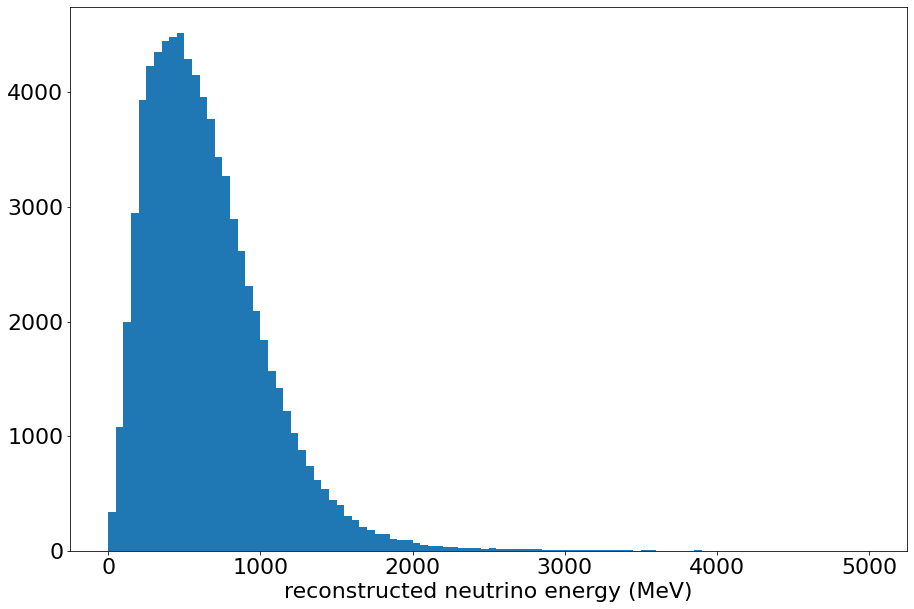

In [68]:
plt.figure(figsize=(15,10))
plt.hist(all_df["kine_reco_Enu"].to_numpy(), weights=all_df["net_weight"].to_numpy(), range=(0, 5000), bins=100)
plt.xlabel("reconstructed neutrino energy (MeV)")
plt.show()

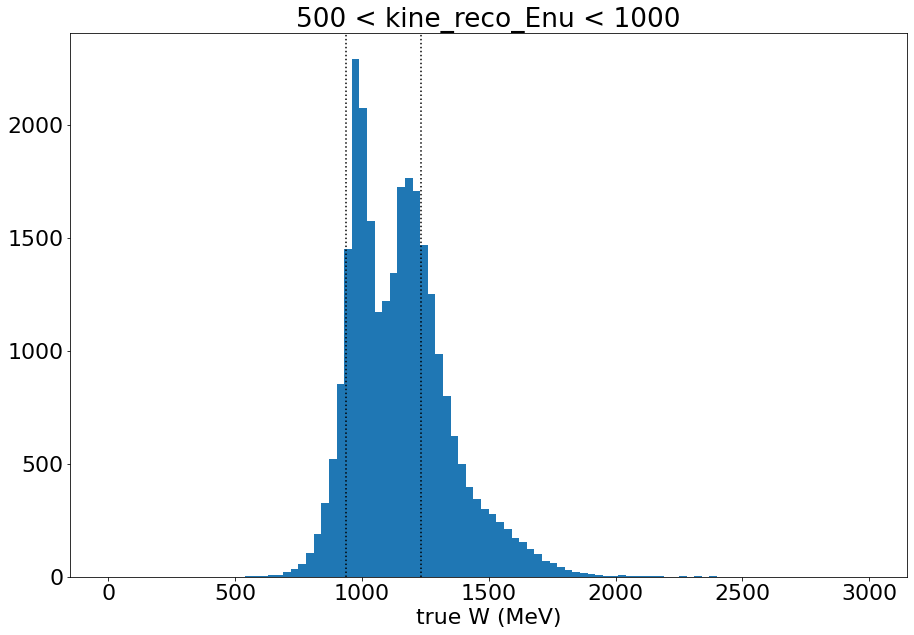

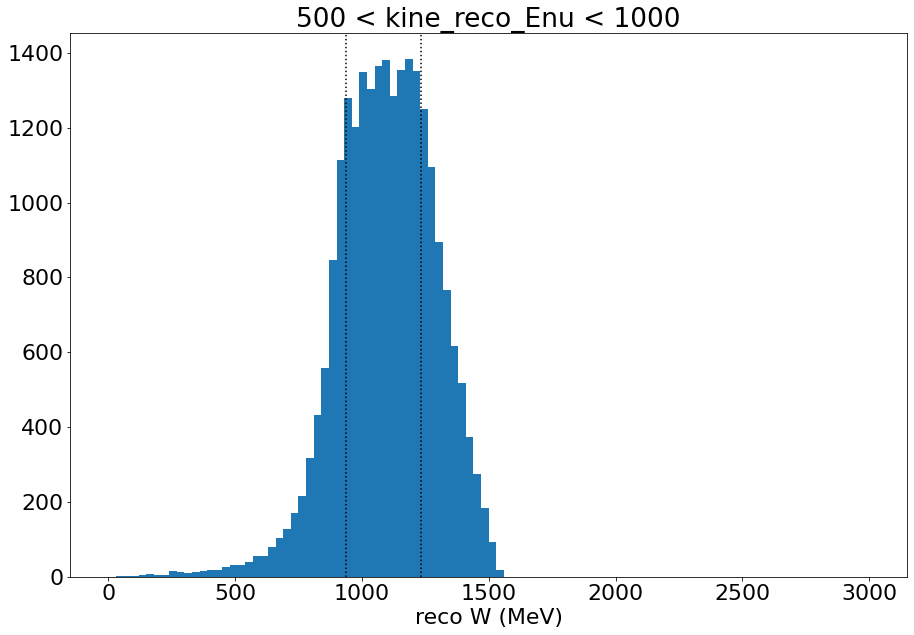

In [79]:
energy_cutoff_low = 500
energy_cutoff_high = 1000

sub_df = all_df.query(f"{energy_cutoff_low} < kine_reco_Enu < {energy_cutoff_high}")

plt.figure(figsize=(15,10))
plt.hist(sub_df["true_W"].to_numpy(), weights=sub_df["net_weight"].to_numpy(), range=(0, 3000), bins=100)
plt.axvline(938.272, ls="dotted", color="k")
plt.axvline(1232, ls="dotted", color="k")
plt.xlabel("true W (MeV)")
plt.title(f"{energy_cutoff_low} < kine_reco_Enu < {energy_cutoff_high}")
plt.show()

plt.figure(figsize=(15,10))
plt.hist(sub_df["reco_W"].to_numpy(), weights=sub_df["net_weight"].to_numpy(), range=(0, 3000), bins=100)
plt.axvline(938.272, ls="dotted", color="k")
plt.axvline(1232, ls="dotted", color="k")
plt.xlabel("reco W (MeV)")
plt.title(f"{energy_cutoff_low} < kine_reco_Enu < {energy_cutoff_high}")
plt.show()